<a href="https://colab.research.google.com/github/juliorodrigues07/manuscript_digit_recognition/blob/tuning/notebooks/digit_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MLP and CNN for Manuscript Digits Recognition**

##[Table of Contents](#scrollTo=ZWjwmu48STPc)

>[Imports and Export Directories](#scrollTo=93DT3HrxkSUL)

>[1. Initial Configurations](#scrollTo=uTG8EXyaM8kx)

>[2. Preprocessing](#scrollTo=RYNQUiCBjlfs)

>[3. Data Visualization](#scrollTo=mfJY4pR2hBwQ)

>[4. Neural Networks](#scrollTo=fQXlJ_IevXRx)

>>[4.1. MLP](#scrollTo=OErx9rlhU9QV)

>>[4.2. CNN](#scrollTo=nz_9iWQWW1DJ)

>>>[4.2.1. Holdout Learning](#scrollTo=Vkw15fhOgcD9)

>>>[4.2.2. Cross Validation](#scrollTo=SSs4M0--g9HE)

>>>[4.2.3. Data Augmentation](#scrollTo=xWl4J-FrALsx)

>>>[4.2.4. Fine Tuning](#scrollTo=56R6pvb_6kVV)

>>>[4.2.5. Saving Model](#scrollTo=XZfAkrTXbG7j)

>[5. Analyzing Results](#scrollTo=QGQ2gyMkDIzq)

>>[5.1. Confusion Matrix](#scrollTo=5woCv7GyVv7A)

>>[5.2. Investigating Errors](#scrollTo=1wg6mGW5D6V5)

>>[5.3. Classifying Own Images](#scrollTo=s8TDQ7Oo-90V)



# **Imports and Export Directories**

In [1]:
from os.path import isdir
from os      import getcwd
from os      import mkdir


if not isdir(f'{getcwd()}/../models'):
    mkdir(f'{getcwd()}/../models')
if not isdir(f'{getcwd()}/../plots'):
    mkdir(f'{getcwd()}/../plots')
if not isdir(f'{getcwd()}/../datasets'):
    mkdir(f'{getcwd()}/../datasets')
if not isdir(f'{getcwd()}/../datasets/digits'):
    mkdir(f'{getcwd()}/../datasets/digits')

# **1. Defining Initial Configurations and HyperParameters**

- Due to not offering support to the F1 metric (Macro F1 - Harmonic mean between precision and recall), we'll develop a custom implementation of it to evaluate the models' performances;

- Macro F1 doesn't consider class imbalance in calculation (unweighted), which tends to present lower values compared to Micro F1 with imbalanced datasets;

- In general, using the Macro F1 is better for evaluating a model, since a low accuracy with labels that correspond to minority classes will have the same impact as the majority ones on the final result;

- For instance, considering a binary classification problem (yes or no) with 80% of instances from the class _yes_ and 20% from the class _no_, a model that has a high accuracy predicting instances from _yes_ class and, in the other hand, extremely low results with _no_ class, tends to mask the results with Micro F1 (global accuracy with true/false positives and true/false negatives);

- The Macro F1 calculates accuracy scores for each classes before outputting the global result, making it more reliable to evaluate a model's performance visualizing its scores for each class and the final unweighted mean;

- Keras models can't be saved with f1 scores as its metrics, since this prevents them from being used properly (not possible to load and predict).

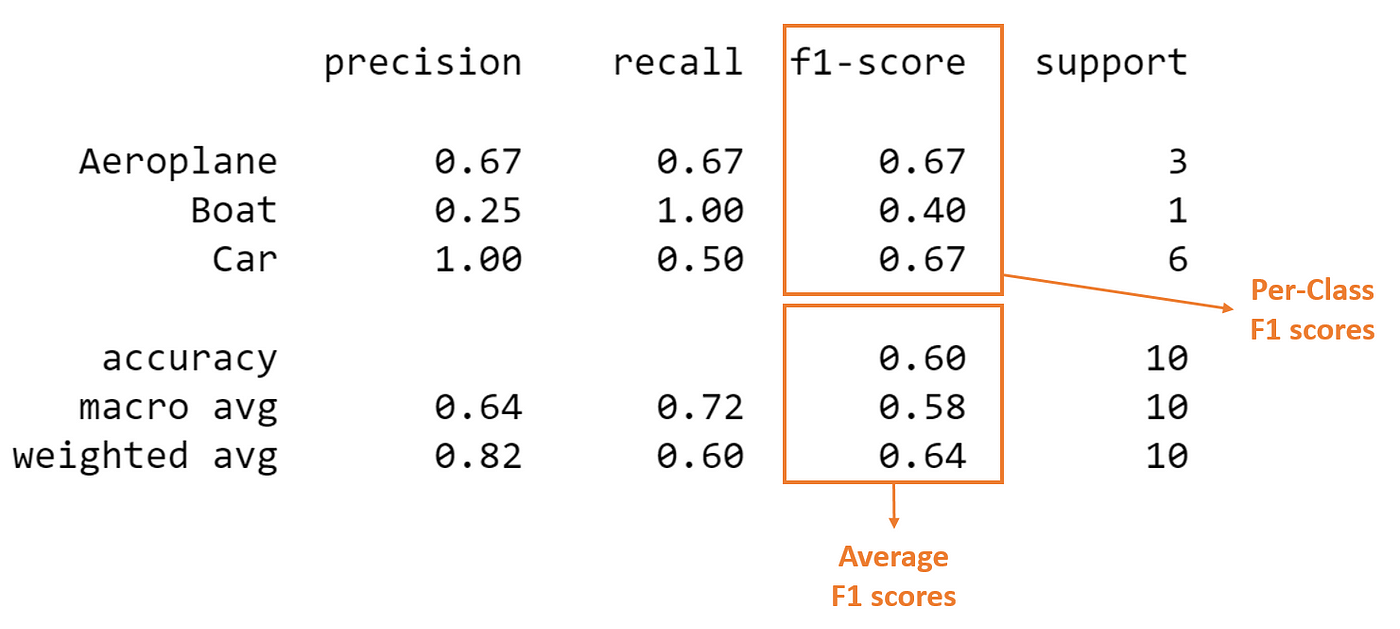

In [2]:
from keras import backend


def f1_score(ground_truth, prediction):

    def recall(ground_truth, prediction):
        '''Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        '''
        true_positives = backend.sum(backend.round(backend.clip(ground_truth * prediction, 0, 1)))
        possible_positives = backend.sum(backend.round(backend.clip(ground_truth, 0, 1)))
        recall = true_positives / (possible_positives + backend.epsilon())
        return recall

    def precision(ground_truth, prediction):
        '''Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        '''
        true_positives = backend.sum(backend.round(backend.clip(ground_truth * prediction, 0, 1)))
        predicted_positives = backend.sum(backend.round(backend.clip(prediction, 0, 1)))
        precision = true_positives / (predicted_positives + backend.epsilon())
        return precision

    precision = precision(ground_truth, prediction)
    recall = recall(ground_truth, prediction)

    return 2 * ((precision * recall) / (precision + recall + backend.epsilon()))

In [3]:
# Optimizer ('SGD', 'RMSprop', 'Adam', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl')
OPTIMIZER = 'adam'

# Loss (Multilabel classification)
LOSS = 'categorical_crossentropy'

# Activation functions ('relu', 'sigmoid', 'softplus', 'softsign', 'softmax', 'tanh', 'selu', 'elu', 'exponential')
ACTV_FUNC = 'relu'
EXIT_FUNC = 'softmax'

# Batch size and number of epochs for training
BATCH_SIZE = 256
N_EPOCHS = 4

# **2. Preprocessing**

- Since images are fundamentally matrices, we need to apply some transformation with that data to fit it to the NN input and possibly speed up its convergence;

- The whole dataset consists just of images, all which resolution is 28x28;

- We'll reshape this matrices to assume an array format (flattening) of length 784 (28 * 28 = 784);

- Then, we'll compress the pixel values (0 to 255) into a new range from 0 to 1, which possibly will make the NNs converge faster.

In [4]:
from keras.utils    import to_categorical
from keras.datasets import mnist
import numpy as np


# Number of target labels (Digits from 0 to 9)
n_classes = 10

# Holdout split of the dataset (train and test)
(raw_training_attributes, raw_training_classes), (raw_test_attributes, raw_test_classes) = mnist.load_data()

# Discretizes the target labels (One-hot encoding)
training_classes = to_categorical(raw_training_classes, n_classes)
test_classes = to_categorical(raw_test_classes, n_classes)

# Converts an image (matrix) with 28 x 28 resolution to an array of size 784
reshaped_training = raw_training_attributes.reshape(60000, 784)
reshaped_test = raw_test_attributes.reshape(10000, 784)

# Normalizes the pixel values (0 to 255) between 0 and 1 (features)
training_attributes = reshaped_training.astype('float32') / 255
test_attributes = reshaped_test.astype('float32') / 255

11490434/11490434 [==============================] - 0s 0us/step


# **3. Data Visualization**

- Plotting a grid of sample images from the dataset.

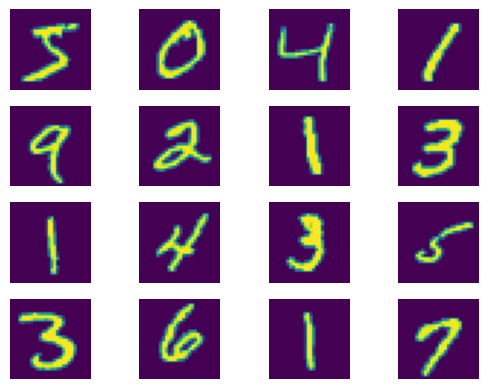

In [ ]:
import matplotlib.pyplot as plt
import math


size = 16
sqrt_size = int(math.sqrt(size))

plt.figure()

for i in range(size):
  plt.subplot(sqrt_size, sqrt_size, i + 1)
  plt.imshow(raw_training_attributes[i])
  plt.axis('off')

plt.show()

# **4. Neural Networks**

Beyond this point, we'll draw our attention to experimenting with neural networks (MLP and CNN) and building an adequate model capable of recognizing manuscript digits.


## **4.1. MLP - Multi-Layer Perceptron**

- Simple _holdout_ learning, with 60k instances for training and 10k for validation (~85% | 15%);

- Completely connected neural network with two hidden layers.


In [ ]:
from keras.layers import Dense
from keras        import Sequential


# Defining the structure of the NN (number of layers, neurons, activation...)
dnn_model = Sequential([
    Dense(784, activation=ACTV_FUNC, input_dim=training_attributes.shape[1]),
    Dense(260, activation=ACTV_FUNC),
    Dense(130, activation=ACTV_FUNC),
    Dense(n_classes, activation=EXIT_FUNC)
])

# NN summary and its training
dnn_model.summary()
dnn_model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=[f1_score])
dnn_model.fit(training_attributes, training_classes,
              batch_size=BATCH_SIZE, epochs=N_EPOCHS, verbose=1)

# Model's performance
dnn_results = dnn_model.evaluate(test_attributes, test_classes, verbose=0)
print(f'\nLoss:      {str(round(dnn_results[0] * 100, 2))}%')
print(f'F1 Score: {str(round(dnn_results[1] * 100, 2))}%')

dnn_model.save(f'{getcwd()}/../models/DNN_tmp.keras')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 784)               615440    
                                                                 
 dense_1 (Dense)             (None, 260)               204100    
                                                                 
 dense_2 (Dense)             (None, 130)               33930     
                                                                 
 dense_3 (Dense)             (None, 10)                1310      
                                                                 
Total params: 854780 (3.26 MB)
Trainable params: 854780 (3.26 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/4
235/235 [==============================] - 12s 9ms/step - loss: 0.2571 - f1_score: 0.9130
Epoch 2/4
235/235 [==============================] -

## **4.2. CNN - Convolutional Neural Network**

- Main application with images, ideal for computer vision tasks;

- New arcuitecture elements like filtering and downsampling layers;

- Often provides better results compared to a simple MLP, or even more sophisticated NNs.

![CNN](https://i.ibb.co/WktNrSG/gec2.jpg)

- About the CNN architecture:

    - **Convolutional Layer** (Conv2D): Extracts N filter maps (based on the number of filters) using a weighted feature detector (i.e., 2D matrix or kernel) that sweeps across the entire image performing element wise multiplications. In this case, it's used _same_ padding, which indicates that the output layer has the same size as the input layer (information preservation);

    ![Conv](https://i.ibb.co/L02sZ85/gec.jpg)

    - **Pooling Layer** (MaxPool2D): Acts as a downsampler performing dimensionality reduction. A, unweighted filter sweeps across the image, in this case selecting pixels which have the maximum value in the neighborhood (i.e., kernel size);

    ![MaxPool](https://i.ibb.co/NnDxRKp/maxpool.jpg)

    - **Dropout**: A regularization method where a proportion of nodes in the layer are randomly ignored for each training sample. This may force the network to learn features in a distributed way, also improving generalization and reducing overfitting.

    ![Dropout](https://i.ibb.co/Z63Kftm/dropout.jpg)

    - **Batch Normalization**: Technique that improves training stability and accelerates convergence, normalizing the activations of each layer. It also adds some noise to each layer during training, acting as a form of regularization like _dropout_. It's often used after convolution and leads to better generalization on unseen data.

    - The dense layers are, in graph terminology, fully connected, which means that each neuron is connected with every other neuron from the previous and successor layers. However, since we're dealing with a feedforward NN, it can be visualized as a directed acyclic graph (i.e., information only travels forward through the nodes and cannot "go back" to previous ones);

    - The activation function used through all the CNN layers (except for the last one) is ReLU (Rectified Linear Unit), which is used to add non-linearity to the network, since images are non-linear. Also, the use of convolutional and pooling layers often reduces the computational cost on fitting the model (dimensionality reduction), compared to simpler MLPs.

In [5]:
from keras.layers import MaxPool2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Conv2D


# Base arbitrary CNN architecture for initial experimentation
def create_model():

    model = Sequential()

    # Initial pair of convolutional layers
    model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='same', activation=ACTV_FUNC, input_shape=(28, 28, 1)))
    model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='same', activation=ACTV_FUNC))

    # Downsampling layer picking maximal values by filtering pixel neighborhoods
    model.add(MaxPool2D(pool_size=(2, 2)))

    # Dropout step (Randomly discards neurons at each N training steps to reduce overfitting)
    model.add(Dropout(0.25))

    # Final pair of convolutional layers, again along with pooling layer and dropout step
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation=ACTV_FUNC))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation=ACTV_FUNC))
    model.add(MaxPool2D(pool_size=(2, 2), strides=(2,2)))
    model.add(Dropout(0.25))

    # Flattening layer that maps the features in an 1D array (e.g., 4x4 matrix into 16 length array)
    model.add(Flatten())

    # Hidden layer completely connected with output layer (dropout applied between them)
    model.add(Dense(256, activation=ACTV_FUNC))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation=EXIT_FUNC))

    model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=['accuracy'])
    return model

### **4.2.1. Holdout Learning**


In [ ]:
# Data resizing, adapting to CNN utilization
cnn_training_attributes = training_attributes.reshape(60000, 28, 28, 1)
cnn_test_attributes = test_attributes.reshape(10000, 28, 28, 1)

# CNN training
cnn_model = create_model()
cnn_model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=[f1_score])
cnn_model.fit(cnn_training_attributes, training_classes,
              epochs=N_EPOCHS, batch_size=BATCH_SIZE)

# Model's performance
cnn_results = cnn_model.evaluate(cnn_test_attributes, test_classes, verbose=0)
print(f'\nLoss:      {str(round(cnn_results[0] * 100, 2))}%')
print(f'F1 Score: {str(round(cnn_results[1] * 100, 2))}%')

cnn_model.save(f'{getcwd()}/../models/CNN_tmp.keras')

Epoch 1/4
235/235 [==============================] - 6s 20ms/step - loss: 0.2871 - f1_score: 0.8957
Epoch 2/4
235/235 [==============================] - 4s 18ms/step - loss: 0.0756 - f1_score: 0.9773
Epoch 3/4
235/235 [==============================] - 4s 18ms/step - loss: 0.0577 - f1_score: 0.9830
Epoch 4/4
235/235 [==============================] - 4s 19ms/step - loss: 0.0432 - f1_score: 0.9868

Loss:      2.07%
F1 Score: 99.31%


### **4.2.2. Cross Validation**

- Holdout learning can be deceiving when it comes to evaluating models, since we're constantly testing with a fixed portion of the dataset;

- Therefore, we'll make use of a stratified k-fold cross validation to obtain more reliable results;

- Stratified K-Fold CV maintains the target classes proportion between each fold. For instance, a binary problem whose dataset that contains 80% of instance from class A and 20% of class B, will have each fold with the same proportion between classes to even the training steps and avoid underfitting (e.g., training almost only with class A instances and testing with class B instances);

- We will split the dataset in fold (5 in this case), selecting one of them at a time to be our test set and the remaining one used in training (i.e., multiple holdouts with different splits);

- The final result will be the average of the f1 scores obtained from each holdout learning step with the k different splits.

In [53]:
from sklearn.model_selection import RepeatedStratifiedKFold


# Whole dataset for fitting and saving final models
features = np.append(raw_training_attributes, raw_test_attributes)
classes = np.append(raw_training_classes, raw_test_classes)

# Preprocessing
reshaped_features = features.reshape(70000, 784)
training_features = reshaped_features.astype('float32') / 255

cnn_final_features = training_features.reshape(70000, 28, 28, 1)
final_classes = to_categorical(classes, n_classes)

# 5-fold cross validation repeated 10 times for model evaluation
f1_per_fold, loss_per_fold = list(), list()
kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)

# KFold.split method doesn't support target which was one-hot encoded
for train, test in kfold.split(cnn_final_features, classes):

    cv_model = create_model()
    cv_model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=[f1_score])
    cv_model.fit(cnn_final_features[train], final_classes[train],
                           batch_size=BATCH_SIZE, epochs=N_EPOCHS, verbose=0)

    # Gathering the results
    scores = cv_model.evaluate(cnn_final_features[test], final_classes[test], verbose=0)
    f1_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

print('\nResults: Average F1 Score and Loss\n')
print(f'F1 Score: Mean - {round(np.mean(f1_per_fold), 2)}% | Std - {round(np.std(f1_per_fold), 2)}')
print(f'Loss:     Mean -  {round(np.mean(loss_per_fold) * 100, 2)}%')


Results: Average F1 Score and Loss

F1 Score: Mean - 99.05% | Std - 0.1
Loss:     Mean -  3.2%


### **4.2.3. Data Augmentation**

- We'll use an annealing method to make the NN's optimizer converge faster and closer to the global minimum of the loss function;

- Having a decreasing learning rate during the training can help to reach the global minimum more efficiently;

- Also, we'll use a second _callback_ to reduce training time, stopping the training process if the monitored metric (f1 score, accuracy, loss, ...) doesn't improve after a determined number of epochs passed;

- Since NNs in general, are more prone to overfitting than simple ML algorithms (more complex, much larger number of parameters and nonlinear activation functions are just a few aspects that allow provides higher capacity to NNs to learn complex patterns in data), we'll artificially expand the dataset to create a more robust model that generalizes well;

- The core idea is to alter the data with small transformations to reproduce variations that could occur when someone is writing a digit (e.g., digit isn't centered, different scale due to writing smaller/bigger numbers, ...);

- However, we'll not apply vertical flips, nor extreme rotations, since it could lead to misclassifying symmetrical numbers such as 6 and 9.

![Augmentation](https://i.ibb.co/vx0K4Dx/augment.jpg)

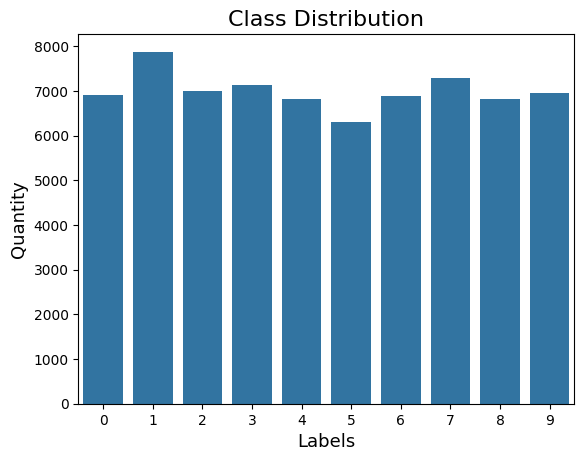

In [ ]:
import seaborn as sns
import pandas  as pd


class_dataset = pd.DataFrame()
class_dataset['Labels'] = list(classes)

plt.title('Class Distribution', fontsize=16)
sns.countplot(class_dataset, x='Labels')
plt.ylabel('Quantity', fontsize=13)
plt.xlabel('Labels', fontsize=13)
plt.show()

- Since the dataset is somewhat balanced, with no major discrepancies between the absolute number of instances of each label between each other, we won't apply oversampling and/or undersampling techniques;

- Also because of that, we can apply the data augmentation process selecting random instances without making relevant impacts in class distribution (We could also execute a stratified data augmentation to be certain of that);

- In case of a unbalanced dataset, the model would benefit more from a targeted augmentation, selecting minority labels to apply the transformations, executing augmentation and oversampling at the same time;

- We can observe better results in both _loss_ and _f1 score_ by just expanding our dataset with simple transformations. The model now is more robust and capable of generalizing better the data.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks           import ReduceLROnPlateau
from keras.callbacks           import EarlyStopping
from keras.optimizers          import Adam


# The learning rate is reduced by half if the accuracy doesn't improve after each 3 epochs past
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                            patience=2, verbose=1, mode='min',
                                            min_delta=0.002, min_lr=0.00001)

early_stop = EarlyStopping(monitor='val_loss', min_delta=0.002, patience=5,
                           verbose=1, mode='min', restore_best_weights=True)

data_aug = ImageDataGenerator(featurewise_center=False,
                              samplewise_center=False,
                              featurewise_std_normalization=False,
                              samplewise_std_normalization=False,
                              zca_whitening=False,
                              rotation_range=10,          # Randomly rotate images in the range (0 to 180 degrees)
                              zoom_range=0.1,             # Randomly zooms images
                              width_shift_range=0.1,      # Randomly shift images horizontally
                              height_shift_range=0.1,     # Randomly shift images vertically
                              horizontal_flip=False,
                              vertical_flip=False)

# The default learning rate value is 0.001, therefore we'll to manually set a higher value for the optimizer
augmented_model = create_model()
augmented_model.compile(optimizer=Adam(learning_rate=0.002), loss=LOSS, metrics=[f1_score])

data_aug.fit(cnn_training_attributes)
augmented = augmented_model.fit(data_aug.flow(cnn_training_attributes, training_classes, batch_size=BATCH_SIZE),
                                epochs=30, validation_data=(cnn_test_attributes, test_classes),
                                steps_per_epoch=cnn_training_attributes.shape[0] // BATCH_SIZE,
                                callbacks=[learning_rate_reduction, early_stop])

augmented_results = augmented_model.evaluate(cnn_test_attributes, test_classes, verbose=0)
print(f'\nLoss:      {str(round(augmented_results[0] * 100, 2))}%')
print(f'F1 Score: {str(round(augmented_results[1] * 100, 2))}%')

Epoch 1/30
234/234 [==============================] - 21s 81ms/step - loss: 0.3738 - f1_score: 0.8676 - val_loss: 0.0368 - val_f1_score: 0.9875 - lr: 0.0020
Epoch 2/30
234/234 [==============================] - 20s 86ms/step - loss: 0.1147 - f1_score: 0.9666 - val_loss: 0.0226 - val_f1_score: 0.9916 - lr: 0.0020
Epoch 3/30
234/234 [==============================] - 19s 82ms/step - loss: 0.0902 - f1_score: 0.9744 - val_loss: 0.0245 - val_f1_score: 0.9917 - lr: 0.0020
Epoch 4/30
234/234 [==============================] - 19s 79ms/step - loss: 0.0749 - f1_score: 0.9786 - val_loss: 0.0182 - val_f1_score: 0.9937 - lr: 0.0020
Epoch 5/30
234/234 [==============================] - 20s 86ms/step - loss: 0.0652 - f1_score: 0.9809 - val_loss: 0.0224 - val_f1_score: 0.9923 - lr: 0.0020
Epoch 6/30
234/234 [==============================] - ETA: 0s - loss: 0.0610 - f1_score: 0.9822
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0010000000474974513.
234/234 [==============================] - 

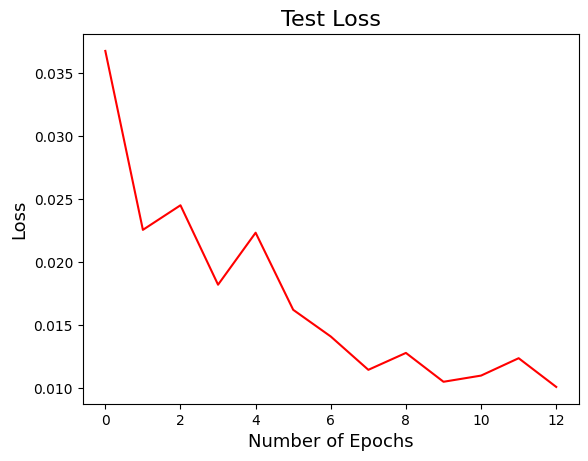

In [ ]:
plt.plot(augmented.history['val_loss'], color='r')
plt.title("Test Loss", fontsize=16)
plt.xlabel("Number of Epochs", fontsize=13)
plt.ylabel("Loss", fontsize=13)
plt.show()

### **4.2.4. Fine Tuning**

- As a final step of the model construction, we need to find the optimal (or close to it) architecture of the CNN and its hyperparameters;

- For the sake of execution time and relative simplicity of the problem, we'll focus on shallow CNNs, also trying to avoid overfitting;

- Regarding the optimizers, we'll stick with Adagrad variations (widely used in CNNs): RMSprop and Adam (the latter combining the advantages of the first two);

- The number of filters will follow an increasing pattern, aiming to capture low-level features in the early layers (e.g., edges and textures), and high-level ones and combination of these low-level features as the data flows deeper in the network;

- This possibly will allow the CNN to learn more abstract and high-level representations of the input images;

- The full search space is as it follows:
    - Number of convolutional layers: **[1, 2, 3]**;
    - Number of dense layers: **[1, 2, 3]**;
    - Convolutional layers dropout coefficient: **[0.1, 0.2, 0.3, 0.4]**;
    - Dense layers dropout coefficient: **[0.3, 0.4, 0.5]**;
    - Number of filters in convolutional layers: **[4, 8, 16, 32, 64]**;
    - Number of neurons in dense layers: **[256, 512, 768, 1024]**;
    - Optimizers: **[Adam, RMSprop]**.

- By performing simple combinatorial analysis, we have 4320 different configurations, which could lead to several days of execution time, when fine tuning with exhaustive grid search;

- To drastically optimize this computationally expensive task, we'll use the BayesianOptimization tuner from KerasTuner, which is basically a heuristic method that searches for promising regions in the hyperparameter search space. The main drawback of using this method, is that we could stagnate in a local minimum/maximum with a hyperparameter set, since it doesn't evaluate all possibilities.

In [7]:
!pip install keras-tuner -q
from keras.layers import BatchNormalization
from keras_tuner  import HyperParameters


def build_model(hp: HyperParameters) -> any:

    kernel_size = (5, 5)

    conv_dropout = hp.Float("conv_dropout", min_value=0.1, max_value=0.4, step=0.1)
    hidden_dropout = hp.Float("hidden_dropout", min_value=0.3, max_value=0.5, step=0.1)

    filter_num = hp.Int('filter_num', min_value=4, max_value=64, step=2, sampling='log')
    units_num = hp.Choice(f'units', [256 * x for x in range(1, 5)])

    conv_layer_num = hp.Int('conv_layer', min_value=1, max_value=3, step=1)
    hidden_layer_num = hp.Int('hidden_layer_num', min_value=1, max_value=3, step=1)

    optimizer = hp.Choice('optimizer', ['adam', 'rmsprop'])
    output_num = training_classes.shape[1]
    input_shape = cnn_training_attributes.shape[1:]

    model = Sequential()

    # 2Conv-2Norm-Pool-Dropout quadruple
    for i in range(conv_layer_num):

        # Input shape changes after first conv-maxpool layer
        if i == 0:
            model.add(Conv2D(filters=filter_num, kernel_size=kernel_size,
                             padding="same", activation=ACTV_FUNC, input_shape=input_shape))
            kernel_size = tuple(element - 2 for element in kernel_size)
        else:
            model.add(Conv2D(filters=filter_num, kernel_size=kernel_size,
                             padding="same", activation=ACTV_FUNC))

        model.add(BatchNormalization())
        model.add(Conv2D(filters=filter_num, kernel_size=kernel_size, padding="same", activation=ACTV_FUNC))
        model.add(BatchNormalization())
        model.add(MaxPool2D(pool_size=(2, 2)))
        model.add(Dropout(conv_dropout))

        # Increases number of filters by a power of 2 with consecutive convolutional layers
        filter_num *= 2

    # Fully-connected
    model.add(Flatten())

    for i in range(hidden_layer_num):
        model.add(Dense(units_num, activation=ACTV_FUNC))
        model.add(Dropout(hidden_dropout))

        # Decreases the number of neurons by a power of 2 with consecutive dense layers
        units_num //= 2

    model.add(Dense(output_num, activation=EXIT_FUNC))

    # Compile and return the model
    model.compile(optimizer=optimizer, loss=LOSS, metrics=['accuracy'])
    return model

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.1 MB/s eta 0:00:00


In [ ]:
from keras_tuner  import BayesianOptimization
from google.colab import files


data_aug.fit(cnn_training_attributes)
tuner = BayesianOptimization(hypermodel=build_model, objective="val_accuracy", max_trials=50,
                             directory=f'{getcwd()}/../models', project_name='tuning')

# Redefining callbacks is necessary, since last fit (augmentation) was done with f1 score
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                            patience=2, verbose=1, mode='min',
                                            min_delta=0.002, min_lr=0.00001)

early_stop = EarlyStopping(monitor='val_loss', min_delta=0.002, patience=5,
                           verbose=1, mode='min', restore_best_weights=True)

try:
    tuner.search(data_aug.flow(cnn_training_attributes, training_classes).x,
                 data_aug.flow(cnn_training_attributes, training_classes).y,
                 epochs=30, batch_size=BATCH_SIZE, validation_data=(cnn_test_attributes, test_classes),
                 callbacks=[learning_rate_reduction, early_stop])

    best_model_info = tuner.get_best_models()[0]
    print(best_model_info.summary())

except KeyboardInterrupt:
    print('Fine tuning abruptely terminated!')

# Saves checkpoints to resume fine tuning later
if tuner.oracle.end_trial:
    !cd && zip -r /checkpoints.zip /models/tuning
    files.download('/checkpoints.zip')

Trial 50 Complete [00h 01m 41s]
val_accuracy: 0.9940000176429749

Best val_accuracy So Far: 0.9966999888420105
Total elapsed time: 01h 53m 31s
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 batch_normalization (Batch  (None, 28, 28, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 28, 28, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 3

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
tuner.results_summary()

Results summary
Results in /content/../models/tuning
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 32 summary
Hyperparameters:
conv_dropout: 0.4
hidden_dropout: 0.3
filter_num: 32
units: 256
conv_layer: 3
hidden_layer_num: 2
optimizer: adam
Score: 0.9966999888420105

Trial 28 summary
Hyperparameters:
conv_dropout: 0.4
hidden_dropout: 0.4
filter_num: 32
units: 512
conv_layer: 3
hidden_layer_num: 1
optimizer: adam
Score: 0.9965999722480774

Trial 29 summary
Hyperparameters:
conv_dropout: 0.4
hidden_dropout: 0.5
filter_num: 32
units: 1024
conv_layer: 3
hidden_layer_num: 3
optimizer: adam
Score: 0.9965999722480774

Trial 30 summary
Hyperparameters:
conv_dropout: 0.1
hidden_dropout: 0.4
filter_num: 32
units: 512
conv_layer: 3
hidden_layer_num: 1
optimizer: rmsprop
Score: 0.9965999722480774

Trial 43 summary
Hyperparameters:
conv_dropout: 0.2
hidden_dropout: 0.3
filter_num: 64
units: 256
conv_layer: 3
hidden_layer_num: 1
optimizer: rmsprop
Score: 0.99650001525

### **4.2.5. Training and Saving Tuned Model**

Fine tuning finished, we'll extract the best hyperparameter set found to train the tuned model with the whole dataset (augmented) and save it.

In [ ]:
# Callbacks need to be redefined, since we won't use validation set, neither its metrics
learning_rate_reduction = ReduceLROnPlateau(monitor='loss', factor=0.5,
                                            patience=2, verbose=1, mode='min',
                                            min_delta=0.002, min_lr=0.00001)

early_stop = EarlyStopping(monitor='loss', min_delta=0.002, patience=5,
                           verbose=1, mode='min', restore_best_weights=True)

best_hps = tuner.get_best_hyperparameters()
best_model = build_model(best_hps[0])

data_aug.fit(cnn_final_features)
best_model.fit(data_aug.flow(cnn_final_features, final_classes, batch_size=BATCH_SIZE),
               epochs=40, steps_per_epoch=cnn_final_features.shape[0] // BATCH_SIZE,
               callbacks=[learning_rate_reduction, early_stop])

best_model.save(f'{getcwd()}/../models/best_model.keras')
files.download(f'{getcwd()}/../models/best_model.keras')

Epoch 1/40
273/273 [==============================] - 26s 79ms/step - loss: 0.7356 - accuracy: 0.7594 - lr: 0.0010
Epoch 2/40
273/273 [==============================] - 22s 79ms/step - loss: 0.1568 - accuracy: 0.9551 - lr: 0.0010
Epoch 3/40
273/273 [==============================] - 22s 80ms/step - loss: 0.1064 - accuracy: 0.9700 - lr: 0.0010
Epoch 4/40
273/273 [==============================] - 22s 79ms/step - loss: 0.0902 - accuracy: 0.9751 - lr: 0.0010
Epoch 5/40
273/273 [==============================] - 22s 80ms/step - loss: 0.0750 - accuracy: 0.9789 - lr: 0.0010
Epoch 6/40
273/273 [==============================] - 21s 78ms/step - loss: 0.0658 - accuracy: 0.9815 - lr: 0.0010
Epoch 7/40
273/273 [==============================] - 22s 80ms/step - loss: 0.0603 - accuracy: 0.9828 - lr: 0.0010
Epoch 8/40
273/273 [==============================] - 22s 79ms/step - loss: 0.0576 - accuracy: 0.9836 - lr: 0.0010
Epoch 9/40
273/273 [==============================] - 22s 80ms/step - loss: 0.05

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **5. Predicting Instances and Analyzing Results**

To perform some analysis, we'll train the tuned model only with training data to visualize some results.

In [54]:
def visualize_predictions(attributes, n, color_map, model):

    final = np.argmax(model.predict(attributes[0 : n], verbose=0), axis=-1)

    fig, ax = plt.subplots(nrows=math.ceil(n / 5), ncols=5)
    plt.axis('off')
    ax = ax.flatten()

    print(f'Predictions for the first {n} images:')
    for i in range(n):
        print(final[i], end=' | ')

        if int((i + 1) % 5) == 0:
            print('\t')

        img = attributes[i].reshape((28, 28))
        ax[i].imshow(img, cmap=color_map, interpolation='nearest')
        ax[i].axis('off')

    print(f'\nFirst {n} from the test set:')

Epoch 1/40
234/234 [==============================] - 25s 83ms/step - loss: 0.8145 - accuracy: 0.7392 - lr: 0.0010
Epoch 2/40
234/234 [==============================] - 28s 121ms/step - loss: 0.1735 - accuracy: 0.9501 - lr: 0.0010
Epoch 3/40
234/234 [==============================] - 19s 81ms/step - loss: 0.1197 - accuracy: 0.9663 - lr: 0.0010
Epoch 4/40
234/234 [==============================] - 18s 78ms/step - loss: 0.0953 - accuracy: 0.9734 - lr: 0.0010
Epoch 5/40
234/234 [==============================] - 18s 78ms/step - loss: 0.0792 - accuracy: 0.9772 - lr: 0.0010
Epoch 6/40
234/234 [==============================] - 19s 81ms/step - loss: 0.0667 - accuracy: 0.9814 - lr: 0.0010
Epoch 7/40
234/234 [==============================] - 19s 82ms/step - loss: 0.0624 - accuracy: 0.9825 - lr: 0.0010
Epoch 8/40
234/234 [==============================] - 20s 86ms/step - loss: 0.0595 - accuracy: 0.9835 - lr: 0.0010
Epoch 9/40
234/234 [==============================] - 19s 81ms/step - loss: 0.0

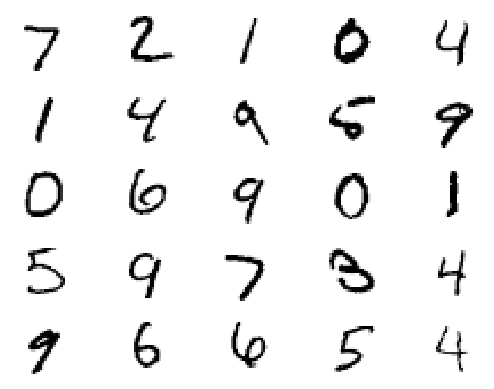

In [32]:
from keras.models import load_model


data_aug.fit(cnn_training_attributes)

# Fits the tuned CNN architecture only with training data
best_hps = tuner.get_best_hyperparameters()
test_model = build_model(best_hps[0])
test_model.fit(data_aug.flow(cnn_training_attributes, training_classes, batch_size=BATCH_SIZE),
               epochs=40, steps_per_epoch=cnn_training_attributes.shape[0] // BATCH_SIZE,
               callbacks=[learning_rate_reduction, early_stop])

test_model.save(f'{getcwd()}/../models/test_model.keras')
loaded_model = load_model(f'{getcwd()}/../models/test_model.keras')
visualize_predictions(attributes=cnn_test_attributes, n=25, color_map='gray', model=loaded_model)

## **5.1. Confusion Matrix**


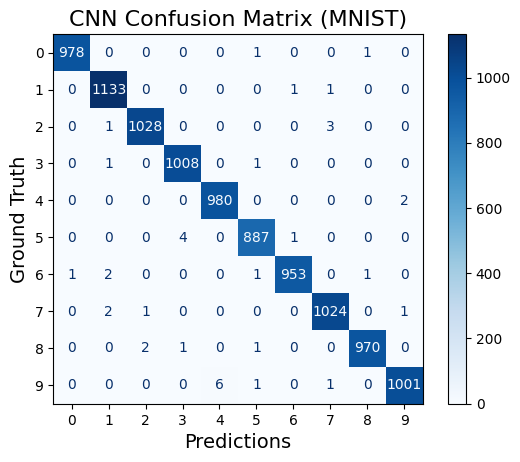

In [55]:
from sklearn.metrics import ConfusionMatrixDisplay


# Executes predictions
final = np.argmax(loaded_model.predict(cnn_test_attributes, verbose=0), axis=-1)

# Formats the data from ground truth to compare with predictions (one-hot -> ordinal encoding)
cnn_test_classes = list()
for i in range(len(test_classes)):
    cnn_test_classes.append(np.argmax(test_classes[i]))

# Labels' names (Digits from 0 to 9)
class_names = [str(i) for i in range(n_classes)]

# Confusion matrix graph plot
ConfusionMatrixDisplay.from_predictions(cnn_test_classes, final, display_labels=class_names, cmap='Blues')
plt.title('CNN Confusion Matrix (MNIST)', fontsize=16)
plt.xlabel('Predictions', fontsize=14)
plt.ylabel('Ground Truth', fontsize=14)

plt.savefig(f'{getcwd()}/../plots/confusion_matrix_cnn.svg', format='svg')
plt.show()

## **5.2. Investigating Errors**

- With the confusion matrix, we can see that the CNN has some little trouble with digit 9, misclassifying some of them as 4. This could be due to not smooth curves and/or disconnection on the top portion;
- To see some of these errors, we'll seek for the misclassifications which were done with the highest certainty (higher probability).

In [56]:
def display_errors(errors_index: np.ndarray, img_errors: np.ndarray,
                   pred_errors: np.ndarray, obs_errors: np.ndarray) -> None:

    n = 0
    n_rows, n_cols = 2, 3
    fig, ax = plt.subplots(n_rows, n_cols)
    plt.axis('off')

    for row in range(n_rows):
        for col in range(n_cols):
            error = errors_index[n]
            ax[row, col].imshow((img_errors[error]).reshape((28, 28)), cmap='gray')
            ax[row, col].set_title(f'Prediction: {pred_errors[error]}\nGround truth :{obs_errors[error]}')
            ax[row, col].axis('off')
            n += 1

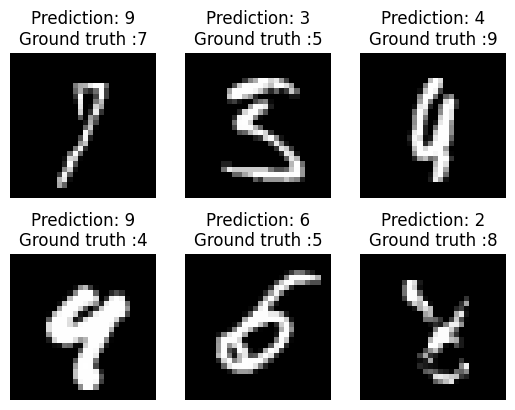

In [57]:
# Probability prediction for each class, one-hot encoding and ground truth
probs = test_model.predict(cnn_test_attributes, verbose=0)
predictions = np.argmax(probs, axis=1)
ground_truth = np.argmax(test_classes, axis=1)

# We can identify erroneous predictions with the difference between predicted labels and true labels
errors = (predictions - ground_truth != 0)

classes_errors = predictions[errors]
prediction_errors = probs[errors]
truth_errors = ground_truth[errors]
attributes_errors = cnn_test_attributes[errors]

# Probabilities of the wrong predicted numbers
prob_errors = np.max(prediction_errors, axis=1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(prediction_errors, truth_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = prob_errors - true_prob_errors
sorted_delta_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors
most_important_errors = sorted_delta_errors[-6:]
display_errors(errors_index=most_important_errors, img_errors=attributes_errors,
               pred_errors=classes_errors, obs_errors=truth_errors)

- The most important errors are also the most intriguing;
- For the 5 and 9 cases (ground truth) for instance, the model's predictions are completely acceptable;
- Some of these errors can also be made by humans, especially for the 9 that is very close to a 4 (disconnected top);

## **5.3. Classifying Own Images**

In [ ]:
# Earlier versions of gdown may have bugs on downloading directories
!pip install --upgrade -q gdown

from os import listdir
import cv2 as cv
import gdown


img_set = list()

digits_dir = f'{getcwd()}/../datasets/digits'
dir_id = '1YehrBNViI4tsiWYA3gcarn9NQ7Sv6LwG'
gdown.download_folder(f'https://drive.google.com/drive/folders/{dir_id}', output=digits_dir, quiet=True)

# Directory containing the list with image files names
images = listdir(digits_dir)

for img in images:

    img = cv.imread(f'{digits_dir}/{img}')
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    # Blurs and binarizes the image to possibly remove noisy data (e.g., salt and pepper)
    blurred = cv.GaussianBlur(gray, (37, 37), 0)
    _, binarized = cv.threshold(blurred, 140, 255, cv.THRESH_BINARY)

    # Resizes the image resolution to 28 x 28 (CNN input size fixed)
    resized = cv.resize(binarized, (28, 28), interpolation=cv.INTER_CUBIC)
    img_set.append(resized)

# Raw data from the real images
raw_instances = np.array(img_set)

# Preprocessing
reshaped = raw_instances.reshape(13, 784)
real_test = reshaped.astype('float32') / 255
cnn_test = real_test.reshape(13, 28, 28, 1)

# Predictions
best_model = load_model(f'{getcwd()}/../models/best_model.keras')
visualize_predictions(attributes=cnn_test, n=len(images), color_map='gray', model=best_model)